In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
spark = SparkSession.builder.appName("Lung Cancer Prediction").getOrCreate()

In [4]:
df = spark.read.csv(r"C:\Users\ASUS\Documents\proyek machine learning\projek 3\survey lung cancer.csv", header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- GENDER: string (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- SMOKING: integer (nullable = true)
 |-- YELLOW_FINGERS: integer (nullable = true)
 |-- ANXIETY: integer (nullable = true)
 |-- PEER_PRESSURE: integer (nullable = true)
 |-- CHRONIC DISEASE: integer (nullable = true)
 |-- FATIGUE : integer (nullable = true)
 |-- ALLERGY : integer (nullable = true)
 |-- WHEEZING: integer (nullable = true)
 |-- ALCOHOL CONSUMING: integer (nullable = true)
 |-- COUGHING: integer (nullable = true)
 |-- SHORTNESS OF BREATH: integer (nullable = true)
 |-- SWALLOWING DIFFICULTY: integer (nullable = true)
 |-- CHEST PAIN: integer (nullable = true)
 |-- LUNG_CANCER: string (nullable = true)



In [6]:
df.show(5)

+------+---+-------+--------------+-------+-------------+---------------+--------+--------+--------+-----------------+--------+-------------------+---------------------+----------+-----------+
|GENDER|AGE|SMOKING|YELLOW_FINGERS|ANXIETY|PEER_PRESSURE|CHRONIC DISEASE|FATIGUE |ALLERGY |WHEEZING|ALCOHOL CONSUMING|COUGHING|SHORTNESS OF BREATH|SWALLOWING DIFFICULTY|CHEST PAIN|LUNG_CANCER|
+------+---+-------+--------------+-------+-------------+---------------+--------+--------+--------+-----------------+--------+-------------------+---------------------+----------+-----------+
|     M| 69|      1|             2|      2|            1|              1|       2|       1|       2|                2|       2|                  2|                    2|         2|        YES|
|     M| 74|      2|             1|      1|            1|              2|       2|       2|       1|                1|       1|                  2|                    2|         2|        YES|
|     F| 59|      1|             1|

In [7]:
null_counts = {col: df.filter(df[col].isNull()).count() for col in df.columns}
print("Missing values per column:")
print(null_counts)

Missing values per column:
{'GENDER': 0, 'AGE': 0, 'SMOKING': 0, 'YELLOW_FINGERS': 0, 'ANXIETY': 0, 'PEER_PRESSURE': 0, 'CHRONIC DISEASE': 0, 'FATIGUE ': 0, 'ALLERGY ': 0, 'WHEEZING': 0, 'ALCOHOL CONSUMING': 0, 'COUGHING': 0, 'SHORTNESS OF BREATH': 0, 'SWALLOWING DIFFICULTY': 0, 'CHEST PAIN': 0, 'LUNG_CANCER': 0}


In [8]:
df = df.withColumn("Gender", when(col("Gender") == "M", 1).otherwise(0))
df = df.withColumn("LUNG_CANCER", when(col("LUNG_CANCER") == "YES", 1).otherwise(0))

In [9]:
df.show(5)

+------+---+-------+--------------+-------+-------------+---------------+--------+--------+--------+-----------------+--------+-------------------+---------------------+----------+-----------+
|Gender|AGE|SMOKING|YELLOW_FINGERS|ANXIETY|PEER_PRESSURE|CHRONIC DISEASE|FATIGUE |ALLERGY |WHEEZING|ALCOHOL CONSUMING|COUGHING|SHORTNESS OF BREATH|SWALLOWING DIFFICULTY|CHEST PAIN|LUNG_CANCER|
+------+---+-------+--------------+-------+-------------+---------------+--------+--------+--------+-----------------+--------+-------------------+---------------------+----------+-----------+
|     1| 69|      1|             2|      2|            1|              1|       2|       1|       2|                2|       2|                  2|                    2|         2|          1|
|     1| 74|      2|             1|      1|            1|              2|       2|       2|       1|                1|       1|                  2|                    2|         2|          1|
|     0| 59|      1|             1|

In [10]:
feature_columns = df.columns[:-1]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_assembled = assembler.transform(df)

In [11]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

In [16]:
df_scaled.select("features", "scaled_features").show(5, truncate=False)

+--------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                      |scaled_features                                                                                                                                                                                                                                                                                          |
+--------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [17]:
(train_data, test_data) = df_scaled.randomSplit([0.8, 0.2], seed=123)

In [19]:
lr = LogisticRegression(featuresCol="scaled_features", labelCol="LUNG_CANCER")
model = lr.fit(train_data)

In [20]:
predictions = model.transform(test_data)

In [21]:
evaluator = BinaryClassificationEvaluator(labelCol="LUNG_CANCER")
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy}")

Accuracy: 0.9576271186440678


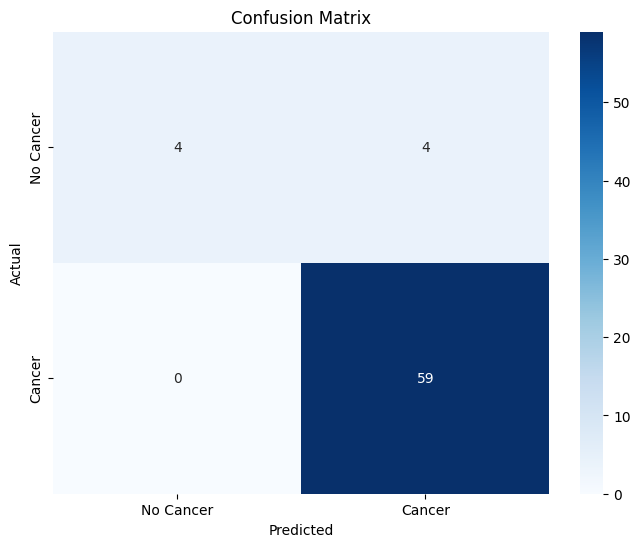

In [23]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_true = predictions.select("LUNG_CANCER").toPandas()
y_pred = predictions.select("prediction").toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=["No Cancer", "Cancer"], yticklabels=["No Cancer", "Cancer"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

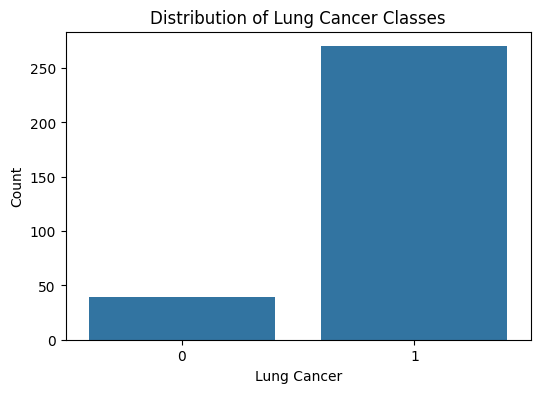

In [25]:
class_distribution = df.groupBy("LUNG_CANCER").count().toPandas()

plt.figure(figsize=(6, 4))
sns.barplot(x="LUNG_CANCER", y="count", data=class_distribution)
plt.xlabel('Lung Cancer')
plt.ylabel('Count')
plt.title('Distribution of Lung Cancer Classes')
plt.show()

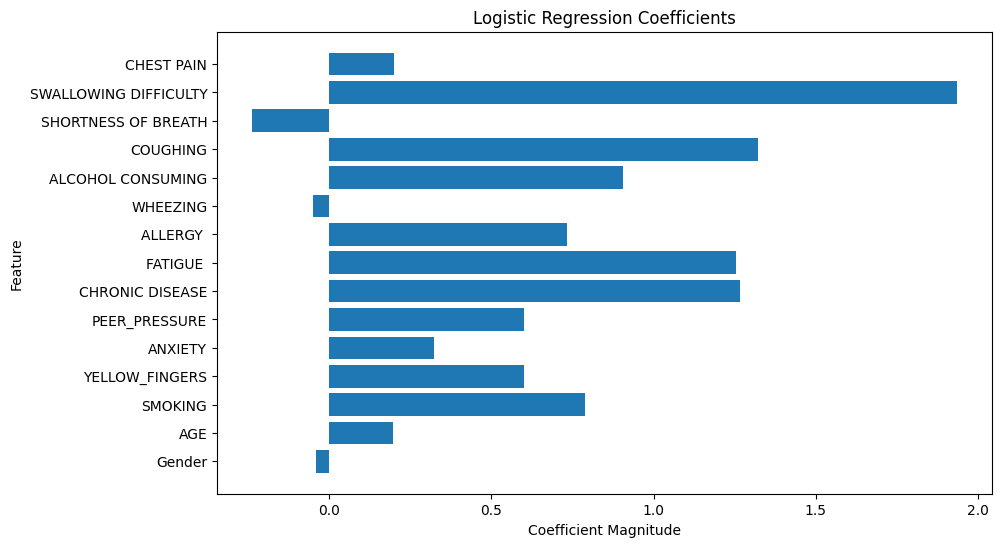

In [26]:
coefficients = model.coefficients.toArray()
feature_names = df.columns[:-1]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, coefficients)
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Logistic Regression Coefficients')
plt.show()